<a href="https://colab.research.google.com/github/hnabid/DEEP-LEARNING/blob/main/vgg19_backbone01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
print(tf.__version__)

2.9.2


In [2]:
!pip install keras
!pip install -U segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 7.6 MB/s 


In [3]:
pip install git+https://github.com/qubvel/segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-0383zeyp
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-0383zeyp
  Running command git submodule update --init --recursive -q


In [4]:
import segmentation_models as sm

sm.set_framework('tf.keras')

sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

In [5]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Add, LeakyReLU, UpSampling2D
from keras.models import Model, load_model
from keras.callbacks import ReduceLROnPlateau

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from skimage.io import imread
from skimage.transform import pyramid_reduce, resize

import os, glob

In [7]:
img_list = sorted(glob.glob('/content/drive/MyDrive/2d_images/*.tif'))
mask_list = sorted(glob.glob('/content/drive/MyDrive/2d_masks/*.tif'))

print(len(img_list), len(mask_list))

267 267


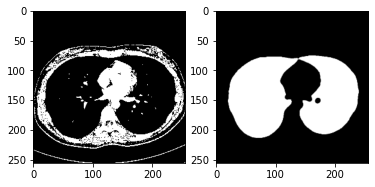

In [8]:
IMG_SIZE = 256

x_data = np.empty((len(img_list), IMG_SIZE, IMG_SIZE, 3), dtype=np.float32)
y_data = np.empty((len(mask_list), IMG_SIZE, IMG_SIZE, 1), dtype=np.float32)

for i, img_path1 in enumerate(img_list):
    img_1 = imread(img_path1)
    img_1 = resize(img_1, output_shape=(IMG_SIZE, IMG_SIZE, 3), preserve_range=True)
    x_data[i] = img_1
    
for i, img_path2 in enumerate(mask_list):
    img_2 = imread(img_path2)
    img_2 = resize(img_2, output_shape=(IMG_SIZE, IMG_SIZE, 1), preserve_range=True)
    y_data[i] = img_2
    
y_data /= 255.

fig, ax = plt.subplots(1, 2)
ax[0].imshow(x_data[12].squeeze(), cmap='gray')
ax[1].imshow(y_data[12].squeeze(), cmap='gray')

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.1)

np.save('/content/drive/MyDrive/x_train.npy', x_train)
np.save('/content/drive/MyDrive/x_val.npy', x_test)
np.save('/content/drive/MyDrive/y_train.npy', y_train)
np.save('/content/drive/MyDrive/y_val.npy', y_test)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(240, 256, 256, 3) (240, 256, 256, 1)
(27, 256, 256, 3) (27, 256, 256, 1)


In [11]:
x_train = np.load('/content/drive/MyDrive/x_train.npy')
x_test = np.load('/content/drive/MyDrive/x_val.npy')
y_train = np.load('/content/drive/MyDrive/y_train.npy')
y_test = np.load('/content/drive/MyDrive/y_val.npy')


print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(240, 256, 256, 3) (240, 256, 256, 1)
(27, 256, 256, 3) (27, 256, 256, 1)


In [12]:
pip install keras-unet-collection

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 67 kB 1.8 MB/s 


In [17]:
import segmentation_models as sm

BACKBONE = 'vgg19'
preprocess_input = sm.get_preprocessing(BACKBONE)



# preprocess input
x_train = preprocess_input(x_train)
x_test = preprocess_input(x_test)

# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model.compile(
    'SGD',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score, sm.metrics.f1_score],
)

print(model.summary())

# fit model
history1=model.fit(
   x=x_train,
   y=y_train,
   batch_size=16,
   epochs=100,
   validation_data=(x_test, y_test),
)

model.save('vgg19_bckbone01_UNet.hdf5')

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   1792        ['input_3[0][0]']                
                                64)                                                               
                                                                                                  
 block1_conv2 (Conv2D)          (None, None, None,   36928       ['block1_conv1[0][0]']           
                                64)                                                         

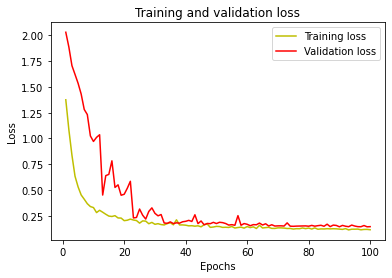

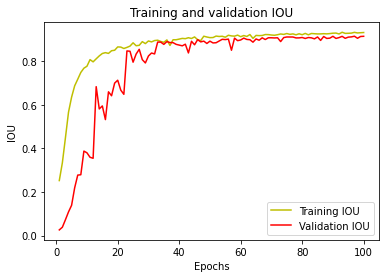

In [18]:
#plot the training and validation accuracy and loss at each epoch
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history1.history['iou_score']
val_acc = history1.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

1/1 [==============================] - 0s 281ms/step


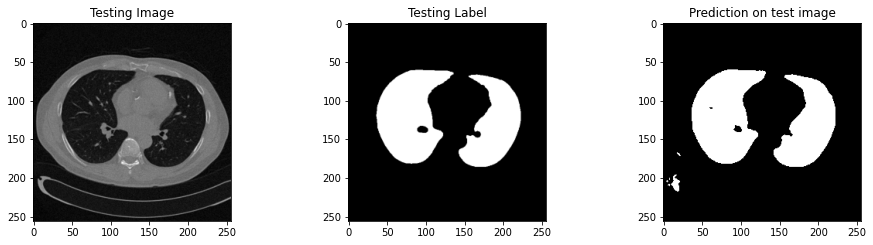

Mean IoU = 0.93000853
1/1 [==============================] - 0s 17ms/step
0.9524822
1/1 [==============================] - 0s 16ms/step
0.938009
1/1 [==============================] - 0s 18ms/step
0.93000853
1/1 [==============================] - 0s 21ms/step
0.93441755
1/1 [==============================] - 0s 18ms/step
0.9414761
1/1 [==============================] - 0s 18ms/step
0.9420553
1/1 [==============================] - 0s 19ms/step
0.9435061
1/1 [==============================] - 0s 27ms/step
0.94495404
1/1 [==============================] - 0s 19ms/step
0.904114
1/1 [==============================] - 0s 18ms/step
0.94237626
1/1 [==============================] - 0s 17ms/step
0.93920016
1/1 [==============================] - 0s 19ms/step
0.9467493
1/1 [==============================] - 0s 20ms/step
0.9302639
1/1 [==============================] - 0s 21ms/step
0.86573565
1/1 [==============================] - 0s 18ms/step
0.935444
1/1 [==============================] - 0s 16m

In [24]:
######################################################



model = model
model_path = "/content/vgg19_bckbone01_UNet.hdf5"

#Load one model at a time for testing.
model = tf.keras.models.load_model(model_path, compile=False)


import random
test_img_number = random.randint(0, x_test.shape[0]-1)
test_img = x_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()


#IoU for a single image
from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(ground_truth[:,:,0], prediction)
print("Mean IoU =", IOU_keras.result().numpy())


#Calculate IoU for all test images and average
 
import pandas as pd

IoU_values = []
for img in range(0, x_test.shape[0]):
    temp_img = x_test[img]
    ground_truth=y_test[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
    
    IoU = MeanIoU(num_classes=n_classes)
    IoU.update_state(ground_truth[:,:,0], prediction)
    IoU = IoU.result().numpy()
    IoU_values.append(IoU)

    print(IoU)